# Module 3 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>
This assignment is a lot more structured than others to keep you on the rails.</p>
</div>


## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. implement the kNN algorithm. Remember...the data + distance function is the model in kNN.
2. evaluate a machine learning algorithm. Because this is a *regression* problem, we will use Mean Squared Error:

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

3. use validation curves to tune a *hyperparameter* of the model. In this case, the hyperparameter is *k*, the number of neighbors.

4. evaluate the *generalization error* of the model.

5. use learning curves to determine if getting more data will improve our model.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
from typing import List, Dict, Tuple, Callable

In [2]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("concrete_compressive_strength.csv")

In [4]:
data[0]

[286.3, 200.9, 0.0, 144.7, 11.2, 1004.6, 803.7, 56.0, 72.99]

In [5]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [6]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds = create_folds(data, 10)

In [8]:
len(folds)

10

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [9]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [10]:
train, test = create_train_test(folds, 0)

In [11]:
len(train)

927

In [12]:
len(test)

103

## kNN

kNN is a bit weird because it's a "lazy" algorithm...it uses the data set (training data) as the model. 
"Eager" algorithms, in constrast, build some kind of generalization of the training data and then throw the training data away.
The basic algorithm is:

```
    1. use the train data as a database
    2. take an observation as a query
    3. calculate the distance between the query and every observation in the database
    4. collect the k nearest observations
    5. if this is classification, return the majority class label of the target.
    6. if this is regression, return the average value of the target.
```

In the real world, there are data structures that make this "find the nearest k" more efficient but we don't need that for 1,000 points.
We also don't need to handle *both* the classification and the regression versions. Let's just handle regression.

Although kNN doesn't result in a model, we can use a higher order function to create a kNN regressor. The interior function will "close over" (a closure) the formal parameter (database) of build_knn. The order of the parameters allows us to vary the k or create a partially applied function where k is fixed:


```
knn = build_knn(train)
knn3 = partial(knn, 3)
result = knn3(query)

# or

result = knn(3, query)

```

It all depends on the context.

For this problem, use **Euclidean distance**.

In [13]:
def build_knn(database):
    def knn(k, query, debug = False):
        euc_distance = []
        
        # calculate euclidean distance
        for obs in database:
            euc_distance += [(sum([(query[i] - obs[i])**2 for i in range(len(query)-1)])**0.5, obs[-1])]
            
        euc_distance.sort(key = lambda obs: obs[0])
        
        if debug == True:
            print("Query:", query)
            for i in range(len(euc_distance[:k])):
                print(f"\t Nearest observation {i}: y = {euc_distance[i][-1]}") 
            print(f"Predicted y = {round(sum([obs[1] for obs in euc_distance[:k]])/k, 4)}")
            print("\n")
            
        return round(sum([obs[1] for obs in euc_distance[:k]])/k, 4)
    return knn

**Note** This is might be your first exposure to a function that creates and returns a function. `database` is a formal parameter of `build_knn` and when you use it in the function body of `knn`, `knn` "closes over" the parameter. Hence, `knn` is a closure.

The saying goes that "closures are a poor person's object and an object is a poor person's closure." Closures are a very common practice in functional programming.

**Note** "database" is just what we call the observations (data set) used in our knn model. During evaluation, it's the training data set. When we're done, it would be the full data set.

### Build kNN

Using Fold 1 as a test set, create train and test sets from our folds. Then build a kNN "model" (function) with k=10. Using the first three members of the test set, calculate predicted concrete compressive strength for them.

**Note** Remember that Lists are 0-indexed so Fold 1 is at index 0.

In [14]:
train, test = create_train_test(folds, 0)
knn = build_knn(train)
result = [knn(10, test[i]) for i in range(3)]
print("Predicted concrete compressive strength", result)

Predicted concrete compressive strength [48.759, 24.244, 30.139]


# Generalization Error

Continuing with k = 10, let's see what our *generalization* error might be.
Although we call it "generalization error", it's not necessarily error but will be the evaluation metric that we've picked.
Generalization error is the error (metric) we expect to see when we use our model on unseen data.
We can calculate this estimate using all 10 folds and rotating through them, using each as the test set.

1. divide data into folds
2. for each fold,
3. use that fold as the test set and the remaining folds as the train set.
4. build a model using the train set.
5. calculate the model's evaluation metric on the test set.
6. calculate the average and standard deviation for the metric and estimate the confidence interval.

But how can we tell if our model is any good?
One way is that you may have some required or optimal value of the evaluation metric in mind.
For example, a classification algorithm might require 97% accuracy or better.

You can also use a *baseline* model.
We often use "null" models as a baseline.
For regression, that's the mean of the target variable (y).
They're called "null" models because they don't use any features to predict the target...they're based on just the target value itself.
(You'd be surprised how many times a null model is good enough for decision making).

If you're using the mean as your model, what does "build a model" entail?
Calculate the mean of y from the training set.
"Calculate the evaluation metric on the test set" entails using the mean as a *constant* prediction for each value of the test set and calculating the evaluation metric (MSE).

So you're going to calculate confidence intervals for *two* models: kNN with k = 3 and the null model (the mean).
Again, the mean of a value is a perfectly legitimate model of the data.

**Note** The mean as a baseline or null model is *not* the same as MSE the evaluation metric. You will have two sets of evaluation metrics, one for the baseline model and one for the kNN model.

The confidence interval function is provided:

In [15]:
import numpy as np
import scipy.stats

### mean_confidence interval

This function calculates the mean of *data* and the confidence bounds of that mean.

**Parameters**

* **data** a List of floating point numbers representing the data.
* **confidence** a scalar (float) indicating the desired confidence bounds. The default is 95% (0.95).

**returns** the mean and a Tuple of the (low, high) values of the *confidence*% bounds. For example, 23.8 (21.2, 26.4)

In [16]:
def mean_confidence_interval(data: List[float], confidence: float=0.95) -> Tuple[float, Tuple[float, float]]:
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, (m-h, m+h)

The first thing we need is a function that takes the real values of y and the predicted values of y and calculates the evaluation metric. In our case, that's MSE:


$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$


In [17]:
def evaluation_metric(actual: List, predicted: List) -> float:
    assert(len(actual) == len(predicted))
    eval_mse = sum([(actual[i] - predicted[i])**2 for i in range(len(actual))])/len(actual)
    return eval_mse

Calculate the generalization error for your kNN and the null model. You will print out 2 confidence intervals.

In [18]:
knn_metrics = []
null_metrics = []
for i in range(0, len(folds)):
    train, test = create_train_test(folds, i)
    knn = build_knn(train)                                                        # build model
    predicted_y = [knn(3, test[i]) for i in range(len(test))]                     # predict_y for test-set 
    actual_y = [obs[-1] for obs in test]                                          # get actual y for test-set
    knn_metrics += [evaluation_metric(actual_y, predicted_y)]                     # eval metrix for KNN
    mean_train_y = sum([obs[-1] for obs in train]) / len(train)                   # calculate the mean of y from train-set
    null_metrics += [evaluation_metric(actual_y, [mean_train_y]*len(actual_y))]   # evaluate metric for null
    
mean_knn, ci_knn = mean_confidence_interval(knn_metrics)
mean_null, ci_null = mean_confidence_interval(null_metrics)
knn_std = np.std(knn_metrics)
print(f"Std of knn metric {knn_std}")
print(f"mean of  knn metric {mean_knn}")
print(f"KNN Confidence Interval: {ci_knn}")
print("\n")
print(f"Std of null metric {np.std(null_metrics)}")
print(f"mean of  null metric {mean_null}")
print(f"NULL Confidence Interval: {ci_null}")

Std of knn metric 21.036493859243667
mean of  knn metric 74.4461237323107
KNN Confidence Interval: (58.58350531142905, 90.30874215319234)


Std of null metric 40.652901371651026
mean of  null metric 279.6118455824952
NULL Confidence Interval: (248.95742824113407, 310.26626292385635)


Is your kNN model better than the null model?

After looking at the above result I can say that the KNN model is much better then null model. As we can see above the standard deviation for knn_metrics is much lower then standard deviation for null_metrics.
We can also observe that the confidence interval for knn_metrics is tighter then confidence interval for null_metrics.

## Setting Hyperparameters

Now let's see if we can find a better k for our problem, concrete compressive strength.
We can do this using *validation* curves.
Validation curves require a few things:

1. pick an evaluation metric (problem dependent)
2. create train and test sets
3. for each proposed value of the hyperparameter:
4. build a model using the train set and the value
5. calculate the evaluation metric using the model against the train set (itself).
6. calculate the evaluation metric using the model against the *test* set.
7. plot the resulting *two* curves.
8. see if they suggest anything

Theoretically, it shouldn't matter which fold you use for your test set for this step.
In practice, you can often get different results and you should average them but we're not going to do that here.

For kNN, this is all a bit confusing because *normally* "build a model" requires the current, proposed value of the hyperparameter you're tuning...but in kNN, we use the hyperparameter *afterwards*. For example, for Decision Trees, the hyperparameter might be "maximum tree depth" and you need to know that value each time you build a new model with the train set.

But "build a model" here is just "chuck all the data into a function". ¯\\_(ツ)_/¯

The only practical difference this makes is that "build a model" is going to go *outside* the loop going over each hyperparamter value instead of inside.

Now we need to do the looping over potential values of k. For *classification*, we prefer odd values of k so that there's always a majority. For regression, we don't care. Let's look at k=[1, 20]:

In [19]:
ks = list(range(1, 21))
test_mse = []
train_mse = []
train, test = create_train_test(folds, 0)                                   # choose the train and test set
for k in ks:                                                                # for each proposed value of hyperparameter
    knn = build_knn(train)                                                  # build model using trains et
    predicted_train = [knn(k, obs) for obs in train]                        # predict y for train set
    predicted_test = [knn(k, obs) for obs in test]                          # predcit y for test set
    actual_train_y = [obs[-1] for obs in train]                             # get actual_y for train-set
    actual_test_y = [obs[-1] for obs in test]                               # get actual_y for test-set
    test_mse += [evaluation_metric(actual_test_y, predicted_test)]          # eval metric for test-set
    train_mse += [evaluation_metric(actual_train_y, predicted_train)]       # eval metric for train-set itself


We can now plot the curves to *hopefully* see if there's a clearly better value for k...one that doesn't overfit or underfit:

In [20]:
import matplotlib.pyplot as plt

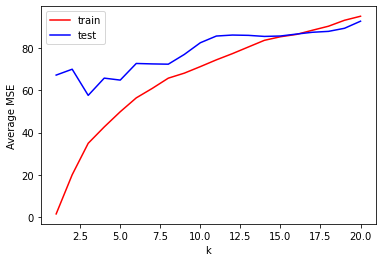

In [21]:
plt.plot(ks, train_mse, 'r', ks, test_mse, 'b')
plt.xlabel('k')
plt.ylabel('Average MSE')
plt.legend(["train", "test"])
plt.show();

Based on your interpretation of the validation curves, what is the best value of k?
Remember, it's not necessarily the lowest value but the lowest value with certain characteristics.

After looking at the above plot I can say that k=8 would give the best result which is shown by a sudden decrese in average MSE followed by sudden increase. The plot above shows low testing error rate at chosen k which mean we have best performance at that k value. 


<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>Normally, you would then revisit the generalization error analysis to see if you've made a real improvement.</p>
</div>


## Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

**standardize**

The `standardize` takes the original data and applies Z-score standardization. It uses the below function to calcualte the z-score.
$$\frac{1}{N}\sum_{x=1}^n \frac{(x-\mu}{\sigma}$$

Parameters:
* **dataset** is the data we want to apply standardization on.

retuns:<br>
it returns the standardized data.

In [22]:
def standardize(dataset):
    features_means, features_std  = [], []
    standardized_dataset = [[] for _ in range(len(dataset))]
    
    for col in range(len(dataset[0])-1):
        features_means += [sum([obs[col] for obs in dataset])/ len(dataset)]                                # calc mean for each features
        features_std += [(sum([(obs[col]-features_means[col])**2 for obs in dataset])/ len(dataset))**0.5]  # calc standard deviation for each feature 
                                              
    for row_num in range(len(dataset)):                                               # Standardize the data
        for col in range(len(dataset[0])-1):
            standardized_dataset[row_num] += [(dataset[row_num][col]-features_means[col])/features_std[col]]
            if col == (len(dataset[0])-2):                                            # add the target column
                standardized_dataset[row_num] += [dataset[row_num][-1]]

    return standardized_dataset

In [23]:
# apply standardization and 
stnd_data = standardize(data)
folds = create_folds(stnd_data, 10)
knn_metrics = []

for i in range(0, len(folds)):
    train, test = create_train_test(folds, i)
    knn = build_knn(train)                                                        # build model
    predicted_y = [knn(3, test[i]) for i in range(len(test))]                     # predict_y for test-set 
    actual_y = [obs[-1] for obs in test]                                          # get actual y for test-set
    knn_metrics += [evaluation_metric(actual_y, predicted_y)]                     # eval metrix for KNN
    
mean_knn_stnd, ci_knn_stnd = mean_confidence_interval(knn_metrics)
knn_stnd_std = np.std(knn_metrics)

print("Before Z-score standardiztion")
print(f"Std of knn metric: {knn_std}")
print(f"mean of  knn metric: {mean_knn}")
print(f"KNN Confidence Interval: {ci_knn}")
print("\n")

print("After Z-score standardiztion")
print(f"Std of knn metric: {knn_stnd_std}")
print(f"mean of  knn metric: {mean_knn_stnd}")
print(f"KNN Confidence Interval: {ci_knn_stnd}")

Before Z-score standardiztion
Std of knn metric: 21.036493859243667
mean of  knn metric: 74.4461237323107
KNN Confidence Interval: (58.58350531142905, 90.30874215319234)


After Z-score standardiztion
Std of knn metric: 17.54325334190329
mean of  knn metric: 73.52829073427185
KNN Confidence Interval: (60.29975866588306, 86.75682280266064)


We can look at the above result to compare the generalizaiton error before and after the z-score standardization. We can observe that after applying Z-score standardization we have a tighter confidence interval and lower standard deviation which tells us that our model has slightly improved. We can also look at the plot below for more verification. 

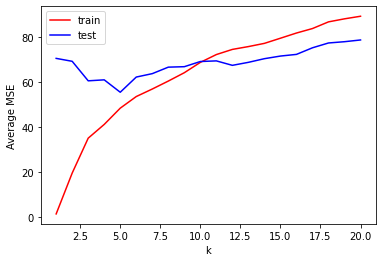

In [24]:
# learning plot
ks = list(range(1, 21))
test_mse = []
train_mse = []
train, test = create_train_test(folds, 0)                                   # choose the train and test set
for k in ks:                                                                # for each proposed value of hyperparameter
    knn = build_knn(train)                                                  # build model using trains et
    predicted_train = [knn(k, obs) for obs in train]                        # predict y for train set
    predicted_test = [knn(k, obs) for obs in test]                          # predcit y for test set
    actual_train_y = [obs[-1] for obs in train]                             # get actual_y for train-set
    actual_test_y = [obs[-1] for obs in test]                               # get actual_y for test-set
    test_mse += [evaluation_metric(actual_test_y, predicted_test)]          # eval metric for test-set
    train_mse += [evaluation_metric(actual_train_y, predicted_train)]       # eval metric for train-set itself

# plot
plt.plot(ks, train_mse, 'r', ks, test_mse, 'b')
plt.xlabel('k')
plt.ylabel('Average MSE')
plt.legend(["train", "test"])
plt.show();

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.